## Dynamics of microbial OTUs

In this notebook we use the multivariate AR(1) model to fit a multivariate time series of marine bacterial operational taxonomic units (OTUs).
The dataset comes from

*Martin-Platero et al. 2018. High resolution time sereis reveals cohesive but short lived communities in coastal plankton. Nature Communications*

First load packages and read in the dataset:

In [10]:
library(rstan)
options(mc.cores=parallel::detectCores())

In [11]:
DAT <- read.csv('../../data/bacterial_OTU.csv',stringsAsFactors=FALSE)

Aggregate the data by phyla, which is indicated in the third column of the dataset:

In [47]:
phyla <- unique(DAT[,3])   #extract unique phyla IDS
PHY   <- data.frame()      #open empty data frame
for(i in 1:length(phyla)){
	xtmp <- apply(as.data.frame(DAT[DAT[,3]==phyla[i],9:ncol(DAT)]),2,sum) #sum all OTUs of that phyla
	PHY  <- rbind(PHY,xtmp)                                                #attach as rows to the empty data frame
}

Now take a look to see how each phyla contributes to the total abundances:

In [48]:
rbind(1:nrow(PHY),rowSums(PHY))  #list row number alongside row sums

1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
1068025,1086966,225623,245003,86525,55012,65740,10889,27331,1939,...,190,73,219,132,53,23,2,1,2,1


We will only model the four most abundant phyla, to keep things simple and fast within Stan.
Below we subset PHY for those phyla:

In [59]:
phy <- PHY[1:4,]

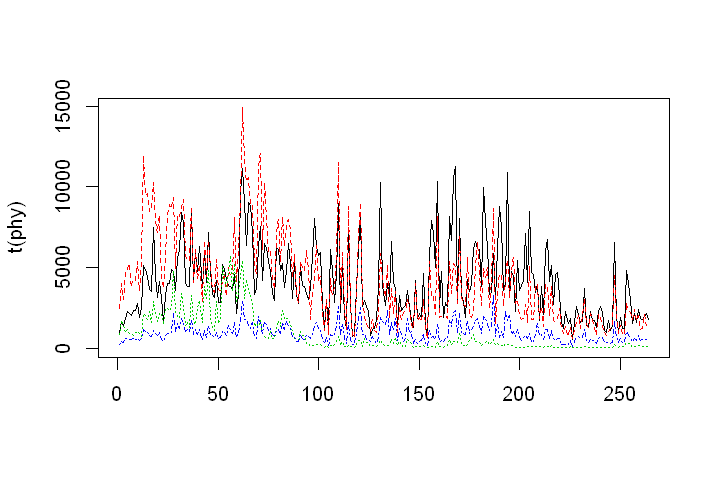

In [60]:
options(repr.plot.width=6, repr.plot.height=4)
matplot(t(phy),type='l')

In [75]:
dat_PHY <- list(T=ncol(phy),
                p=nrow(phy),
                Y=phy)

In [76]:
mod_code <- "data {
	int T;         //length of time series
	int p;         //number of variables
	matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
	matrix[p,p] PHI;     //dynamics matrix
	vector<lower=1E-15>[p] sigma;     //variances of stochastic forcing
	vector[p] init;      //mean of initial conditions as parameter vector
}
model{
	Y[,1] ~ normal(init, sigma);            //distribution of the initial conditions
	for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma);  //conditional predictive distribution
	}
}"

In [65]:
mod <- stan_model(model_code=mod_code)

In [54]:
mcmc <- sampling(mod,data=dat_PHY,iter=2000,warmup=1000,open_progress=TRUE)

In [55]:
mcmc

Inference for Stan model: c48e7550a72050a85f7d86fb4ca9c543.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean      sd     2.5%      25%      50%      75%    97.5%
PHI[1,1]     0.67    0.00    0.10     0.47     0.61     0.67     0.73     0.85
PHI[1,2]     0.03    0.00    0.09    -0.15    -0.03     0.04     0.10     0.21
PHI[1,3]     0.18    0.00    0.16    -0.13     0.08     0.18     0.29     0.49
PHI[1,4]     0.61    0.01    0.41    -0.20     0.34     0.61     0.88     1.41
PHI[2,1]     0.13    0.00    0.09    -0.05     0.08     0.13     0.20     0.31
PHI[2,2]     0.78    0.00    0.09     0.60     0.72     0.78     0.84     0.95
PHI[2,3]     0.37    0.00    0.15     0.08     0.26     0.37     0.47     0.65
PHI[2,4]    -0.42    0.00    0.40    -1.19    -0.69    -0.43    -0.16     0.37
PHI[3,1]     0.01    0.00    0.03    -0.04    -0.01     0.01     0.03     0.06
PHI[3,2]     0.05    0.00    0.0